# SLU14: Model complexity and overfitting - Exercises


---
*Exercises are graded unless otherwise indicated.*

In [1]:
import warnings
import inspect
import base64
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib

from utils import expand_dataset

from sklearn.datasets import load_boston
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import json
from hashlib import sha1 # just for grading purposes

def _hash(obj):
    if type(obj) is not str:
        obj = json.dumps(obj)
    return sha1(obj.encode()).hexdigest()

As a junior data scientist, you are hired by a real estate company to work on their data. The first task they assign to you is to review the work of a previous employee. This employee tried to predict house prices based on a dataset they have, but unfortunately it wasn't performing very well. Let's find out what happened!

### Data

For this exercise notebook, we'll be working with a house price dataset containing several different features related to the house being sold and the seller. Let's first check the data:

In [2]:
# This function is designed to be used in all the exercises

def load_dataset():
    # Loads house prices dataset
    df = pd.read_csv(pathlib.Path('data') / 'house-prices.csv')
    
    return df

In [3]:
# Load data
df = load_dataset()
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SellerAge,SellerName
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,2,2008,WD,Normal,208.5,57,Doris Unger
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,5,2007,WD,Normal,181.5,94,Richard Skinner
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,9,2008,WD,Normal,223.5,49,Seth Gonzalez
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,2,2006,WD,Abnorml,140.0,31,Traci Clark
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,12,2008,WD,Normal,250.0,97,David Johnson


In [4]:
df.shape

(1460, 64)

## Exercise 1 - complex models 


The business owners were short on time, so the employee just took all the data and threw it in a model. After all, with all the fancy algorithms in data science, it's easy to try and, *who knows*, you might even get a good performance from the start and even improve it further with parameter tuning and all that *fancy data science magic*.


<img alt="xkcd_shuffle_data_pile" src="media/xkcd_shuffle_data_pile.png" width="300">


### Exercise 1.1

As a first step, he started by getting the data into the model. He must have noticed that he had a lot of categorical values, and knowing that most models need them to be encoded somehow, he kept it simple and decided to convert each categorical column into a set of dummy variables expanding on each category. 

Function is implemented below:

In [5]:
def encode_categorical(df): 
    df_encoded = pd.get_dummies(df)
    return df_encoded

In [6]:
df = load_dataset()
df_encoded = encode_categorical(df)
print(f"Initial number of columns {df.shape[1]}")
print(f"Encoded number of columns {df_encoded.shape[1]}")

Initial number of columns 64
Encoded number of columns 1677


### Exercise 1.1.1

What does the function try to do? 

* A) Creates copies of the existing columns.
* B) Splits the categorical columns into several integer columns, each corresponding to one unique value.
* C) Creates dummy columns that are later dropped before providing them to the model.
* D) Categorizes each column into optimized intervals and groups.

In [7]:
# answer = 'A' or 'B' or 'C' or 'D'

answer = "B"

In [8]:
assert base64.b64encode(answer.encode()) == b'Qg=='

### Exercise 1.1.2

What problem do you already identify?

* A) Some categorical columns are useless and are only increasing the complexity of the model.
* B) We should have only provided categorical columns to the function.
* C) We should have converted the columns into string.
* D) Label encoding would be more appropriate for the nominal variables.

In [9]:
answer = 'A'



In [10]:
assert base64.b64encode(answer.encode()) == b'QQ=='

### Exercise 1.2

Oh no! Looks like we have code missing.

Fortunately, he documented what he did. Looks like he chose to use a decision tree regressor with max_depth of 7 and min_sample_split of 30.

Can you redo the function?

In [11]:
def decision_tree_regression(X, y): 
    """
    Fit a DecisionTreeRegressor with `max_depth` of 7, and `min_samples_split` 
    of 30 on the provided data
    
    **For reproducibility: Use random state of 42 always**

    Args:
        X (pd.DataFrame): the input DataFrame
        y (pd.Series): the target labels

    Returns: estimator
        estimator (DecisionTreeRegressor): fitted estimator        
    """
    dt = DecisionTreeRegressor(random_state=42, max_depth=7 , min_samples_split = 30)
    dt.fit(X, y)
    
    
    return dt 


Validate the decision tree you've trained on tests below:

In [12]:
df = load_dataset()
df_encoded = encode_categorical(df)

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

dt = decision_tree_regression(X, y)

assert dt.max_depth == 7
assert dt.min_samples_split == 30
assert dt.n_features_in_ == 1676

preds = dt.predict(X)

np.testing.assert_almost_equal(preds[100], 193.0600, 2)
np.testing.assert_almost_equal(preds[1042], 164.8525, 2)


### Exercise 1.3

The employee did not do any evaluation, so let's start by doing one for him. 

Create a small function to produce the two regression metrics you want to use: **mean squared error** and **r2 score**.

Implement it below:

In [13]:
def regresion_metrics(y, preds): 
    """
    Return two regression metrics computed with the provided predictions
    `preds` and the true values `y`: mean squared error and R squared
    
    Args:
        preds (pd.Series): the predictions we want to assess
        y (pd.Series): the true labels

    Returns: mse, r2
        mse (float): mean squared error of predicitons     
        r2 (float): r-squared value of predicitons        
    """
    
    r2 = r2_score(y, preds)
    mse = mean_squared_error(y, preds)
    
    return mse, r2 



In [14]:
df = load_dataset()
df_encoded = encode_categorical(df)

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

dt = decision_tree_regression(X, y)
preds = dt.predict(X)

mse, r2 = regresion_metrics(y, preds)

np.testing.assert_almost_equal(mse, 716.2435, 2)
np.testing.assert_almost_equal(r2, 0.8996, 2)

If you had the last functions right, you had 716 of MSE and 0.89 of R2.

Even though we got a pretty big Mean squared error, which can also relate to the big values we're handling, we get a pretty good R-squared value. 

However, you remember something somebody told you about how every time you evaluate on the data you used to train you lose the ability to tell whether you are overfitting the data you happen to have at hand. So you decide to also apply a held-out test set and check the results:



In [15]:
df = load_dataset()
df_encoded = encode_categorical(df)
print("Number of features: {}".format(len(df_encoded.columns)))

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt = decision_tree_regression(X_train, y_train)

preds = dt.predict(X_test)
mse, r2 = regresion_metrics(preds, y_test)

print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared: {:.2f}".format(r2))


Number of features: 1677
Mean Squared Error: 1320.16
R-squared: 0.77


Looks like the results were not so good after all...

But you can do better!

### Exercise 1.4

Let's plot the decision tree used for this problem. Implement below a function plotting the decision tree:

- Showing all labels
- Not showing impurity labels
- Do not change the display of ‘values’ and/or ‘samples’ to be proportions

Optional (for aesthetics):
- Fill the nodes with `filled=True`
- Use `rounded=True` to have nice rounded corners


In [16]:
def plot_dt_regressor(dt, feature_names): 
    """
    Generate plot of decision tree given the estimator and its 
    feature names. 

    Args:
        dt (DecisionTreeRegressor): fitted decision tree estimator        
        feature_names (list): list of feature names

    Returns: plot_annots
        plot_annots (list): plot annotations     

    """
    plt.subplots(figsize=(100, 20))  # this helps you control the figure size 
    
    plot_annots = plot_tree(decision_tree = dt, feature_names = feature_names, 
                            label = "all", impurity = False, proportion = True,
                            filled = True, rounded = True)
    
    return plot_annots 


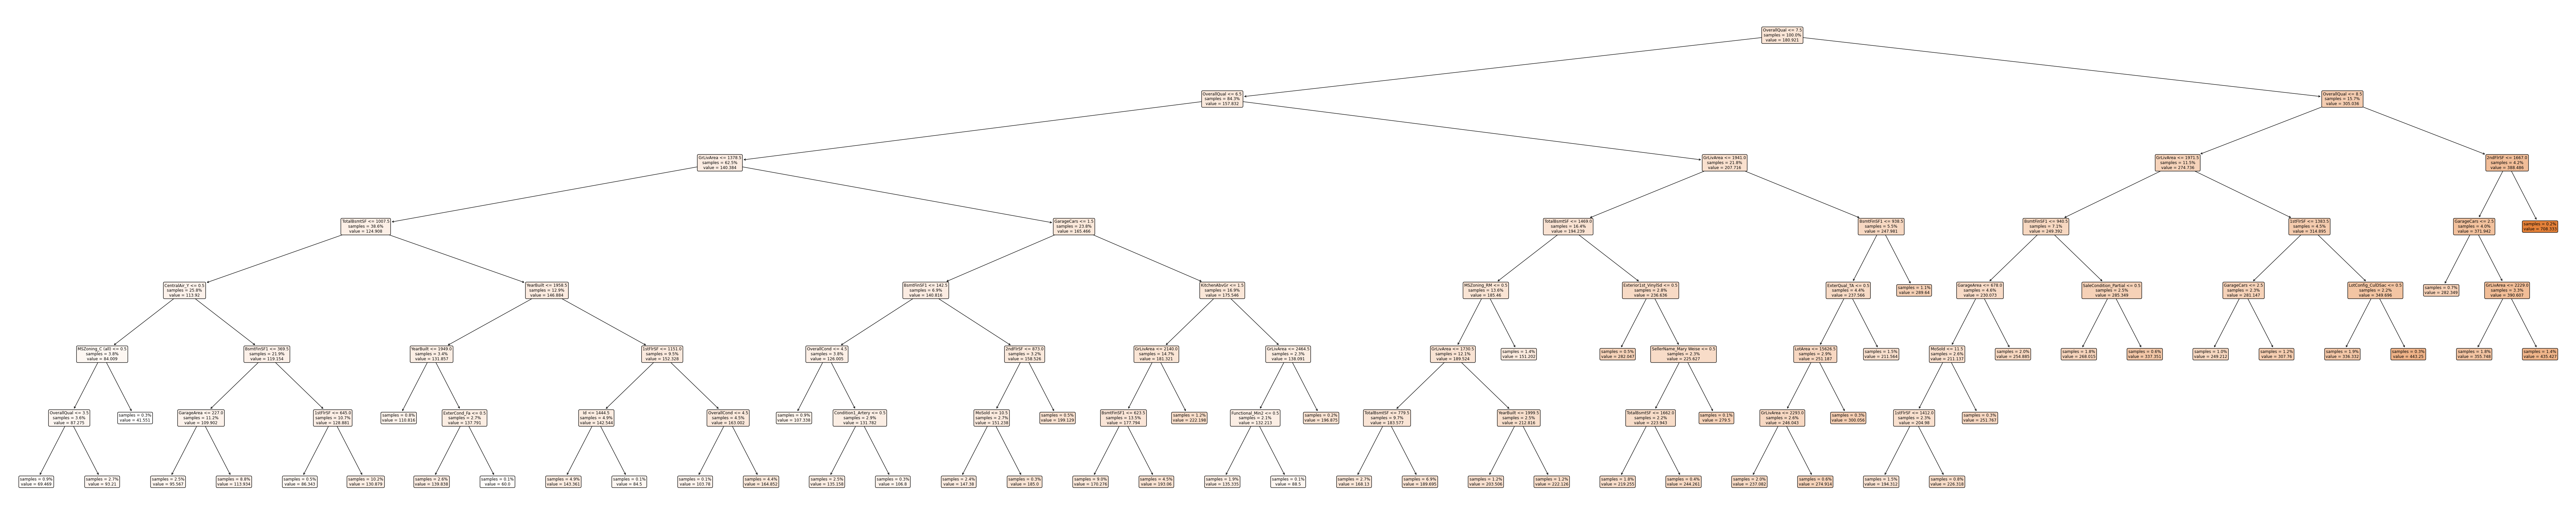

In [17]:
df = load_dataset()
df_encoded = encode_categorical(df)

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

dt = decision_tree_regression(X, y)
tree_plot = plot_dt_regressor(dt, X.columns)

sig = inspect.signature(plot_dt_regressor)
assert set(sig.parameters.keys()) == {'dt', 'feature_names'}
all_text = ''.join([tree_plot[i].get_text() for i in range(len(tree_plot))])
assert 'OverallQual' in all_text

first_node_feature = tree_plot[0].get_text().split('<')[0].strip()
assert _hash(first_node_feature) == '0204560528837e345e60ecc1eccf33d641a30686'
assert len(tree_plot) == 107

node_10 = tree_plot[10].get_text()
assert 'value = 119.154' in node_10
assert 'BsmtFinSF1' in node_10, node_10


Check the feature names in the plot against the feature names in the dataframe you used:

In [18]:
df_encoded

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SellerName_Willie Lee,SellerName_Willie Meyer,SellerName_Willie Smith,SellerName_Wilma Kerr,SellerName_Yu Deitz,SellerName_Yvette Jones,SellerName_Yvette Sailor,SellerName_Yvonne Wayland,SellerName_Zane Roundtree,SellerName_Zoe Grooms
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,0,0,0,0,0,0,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,0,0,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0,0,953,...,0,0,0,0,0,0,0,0,0,0
1456,1457,20,13175,6,6,1978,1988,790,163,589,...,0,0,0,0,0,0,0,0,0,0
1457,1458,70,9042,7,9,1941,2006,275,0,877,...,0,0,0,0,0,0,0,0,0,0
1458,1459,20,9717,5,6,1950,1996,49,1029,0,...,0,0,0,0,0,0,0,0,0,0


### Exercise 1.5

*Hint: To check the decision tree image better, you can save it and open in your own viewer of preference or you double click on the image and it will zoom in)*

You look into your process, dataframe and tree with a senior colleague. What is he most likely to tell you? 

* A) Great job, this seems like a great starter model! 
* B) You clearly need to prune your decision tree
* C) What is a decision tree?
* D) Have you looked into the dataset? There's some pretty random features here...


In [19]:
answer =  'D'

In [20]:
assert base64.b64encode(answer.encode()) == b'RA=='


# Exercise 2 - find the nonsense 

### Exercise 2.1

After this first trial, you proceed with a more methodical approach. There are a few features that should obviously not influence the price and might just add unnecessary complexity to the model. In particular, there are two obvious ones that you should be able to identify and discard.

Can you find them?

Write below which columns (from the initial dataframe) you would remove.


_Hint #1: Look into your dataframe after encoding the categorical features. What feature is exploding the number of variables?_  

_Hint #2: What other non-categorical column has values that equal the number of rows we have?_  

In [21]:
# Example answer:
nonsense_features = ['SellerName', 'Id']


In [22]:
categoricals = []
for col in df.columns:
    categoricals.append(col)
    
categoricals

number_of_uniques_per_category = df.loc[:, categoricals].nunique()
number_of_uniques_per_category

Id               1460
MSSubClass         15
MSZoning            5
LotArea          1073
Street              2
                 ... 
SaleType            9
SaleCondition       6
SalePrice         663
SellerAge          82
SellerName       1459
Length: 64, dtype: int64

In [23]:
assert _hash(sorted(nonsense_features)) == 'a9c3a5038268a67480b94c5206dbb7ef3c54b2d1'


In [24]:
df = load_dataset()
df_removed = df.drop(nonsense_features, axis=1)

df_encoded = encode_categorical(df_removed)

df_encoded.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,1,0,0,0,0,1,0


Great job! That was a reduction of 1677 to 217 columns, or in terms of model, a reduction from 1677 to 217 features. 

Number of features: 217
Mean Squared Error (train): 631.518948649443
R-squared (train): 0.8827710556977868
Mean Squared Error (test): 1307.2533687584917
R-squared (test): 0.7710521042541904


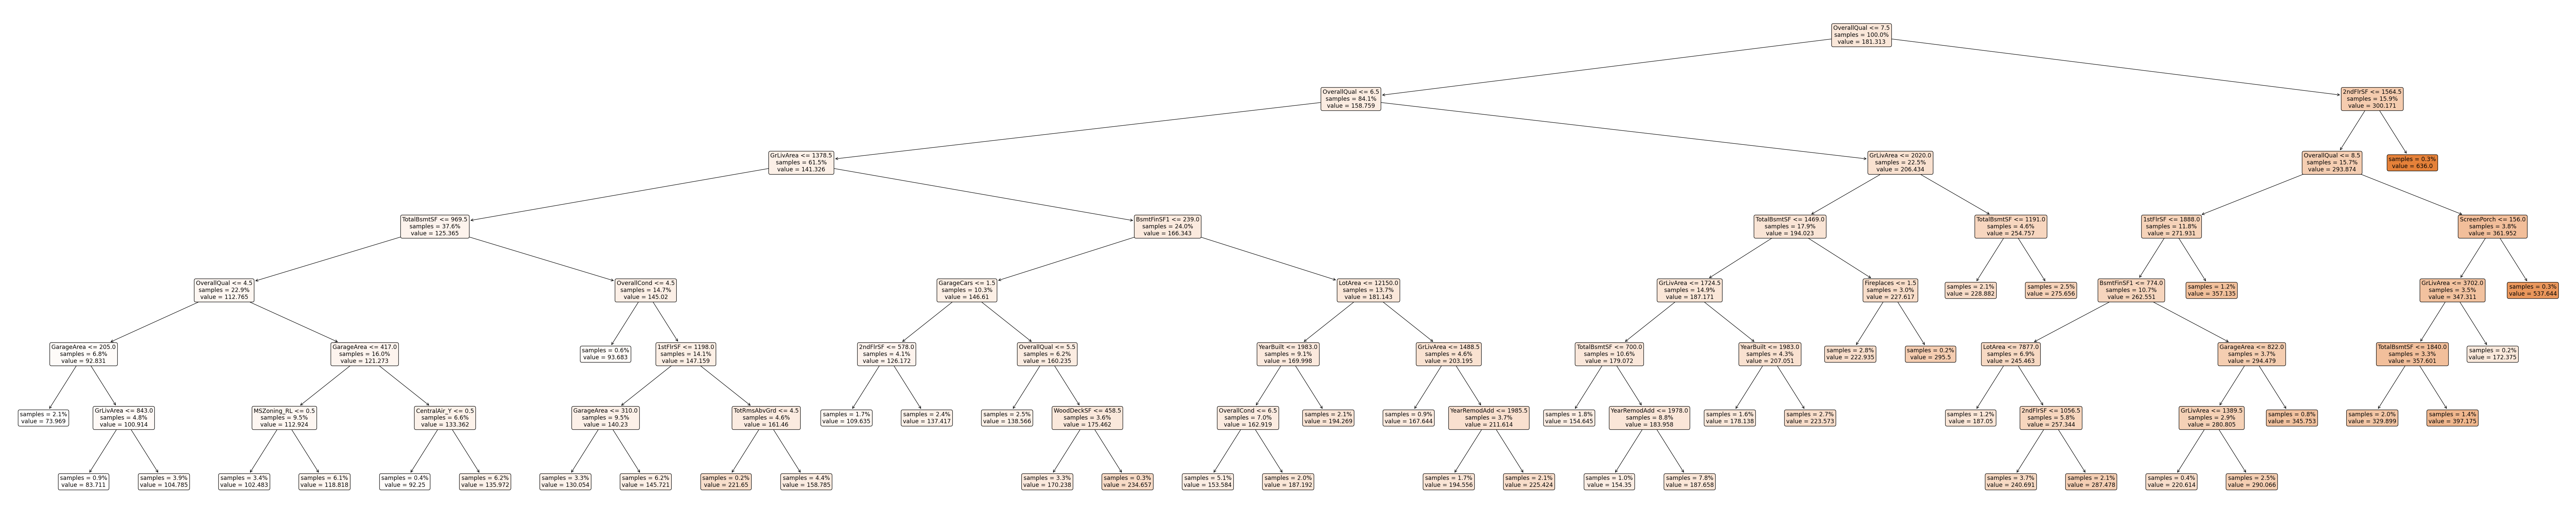

In [25]:
X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']
print("Number of features: {}".format(len(df_encoded.columns)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt = decision_tree_regression(X_train, y_train)

preds = dt.predict(X_train)
mse, r2 = regresion_metrics(preds, y_train)

print("Mean Squared Error (train): {}".format(mse))
print("R-squared (train): {}".format(r2))

preds = dt.predict(X_test)
mse, r2 = regresion_metrics(preds, y_test)

print("Mean Squared Error (test): {}".format(mse))
print("R-squared (test): {}".format(r2))

tree_plot = plot_dt_regressor(dt, X.columns)


We've dropped more than a thousand features and still get the same performance. Even though, depending on the models, these features may generate more or less noise, this shows how important it is to understand the data before you throw it into your model.

### Exercise 2.2

Another way that you can understand the data is by looking into the decision tree image and thinking about the decisions it's making. If you were to "guess" the most important feature given the decision tree, which one would you pick? 

* A) YearRemodAdd
* B) OverallQual
* C) WoodDeckSF
* D) CentralAir_Y

*Hint: To check the decision tree image better, you can save it and open in your own viewer of preference or you double click on the image and it will zoom in)*

In [26]:
answer = 'B' 


In [27]:
assert base64.b64encode(answer.encode()) == b'Qg=='

### Exercise 2.3

Let's continue on these lines and find other features that do not have importance in this dataset. Use the `mutual_information` method and find all of the features with 0.0 mutual information with the target:

*Hint: You have used the `mutual_info_classif` for classification. There is an analogous function for regression in sklearn*

In [28]:
from sklearn.feature_selection import mutual_info_regression

In [29]:

def zero_mutual_information_features(X, y): 
    """
    Use the mutual information method and return all feature names
    where the mutual information is zero.

    **For reproducibility: Use random state of 42 always**

    Args:
        X (pd.DataFrame): the input DataFrame
        y (pd.Series): the target labels

    Returns: plot_annots
        features (list): list of feature names where mutual information is zero     

    """
    # Compute mutual information of the dataset features
    # Hint: use can use the sklearn function here
    mutual_info = mutual_info_regression(X=X, y=y, random_state =42)
    columns = list(X.columns)
    serie_mutual_info = pd.Series(mutual_info, index = columns)
    
    
    # Extract the feature names where the mutual information is zero
    features = []
    for i in range(len(serie_mutual_info)):
        if serie_mutual_info[i] == 0:
            features.append(serie_mutual_info.index[i])
   

    return features 


In [30]:
df = load_dataset()
df_removed = df.drop(nonsense_features, axis=1)
df_encoded = encode_categorical(df_removed)

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

bottom_mut_info_features = zero_mutual_information_features(X, y)

assert _hash(sorted(bottom_mut_info_features)) == '9c41aa9d5505800207c36f3cb3ecdf9c1d58ea15'


If we now drop these features we should achieve similar values on our data. Check this below:

In [31]:
df = load_dataset()
df_removed = df.drop(nonsense_features, axis=1)
df_encoded = encode_categorical(df_removed).drop(bottom_mut_info_features, axis=1)

print('Number of features: {}'.format(len(df_encoded.columns)))

X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop('SalePrice', axis=1), 
    df_encoded['SalePrice'], 
    test_size=0.3, 
    random_state=42
)

dt = decision_tree_regression(X_train, y_train)

preds = dt.predict(X_train)
mse, r2 = regresion_metrics(preds, y_train)

print('Mean Squared Error (train): {:.2f}'.format(mse))
print('R-squared (train): {:.2f}'.format(r2))

preds = dt.predict(X_test)
mse, r2 = regresion_metrics(preds, y_test)

print('Mean Squared Error (test): {:.2f}'.format(mse))
print('R-squared (test): {:.2f}'.format(r2))

Number of features: 165
Mean Squared Error (train): 631.52
R-squared (train): 0.88
Mean Squared Error (test): 1642.79
R-squared (test): 0.71


In this case, our training values are not too different, but our test values decreased. So what's that all about? If these features brought nothing to the table when it came to predicting our target, shouldn't the performance stay the same?

There are a couple of things to take into consideration here as we've been using a fixed model with some random parameters we've chosen to keep it simple:

* The parameters may not be adequate and may be leading to overfitting
* These "random" features may actually have been having a regularization effect on the training, preventing it to overfit too much to other features containing more information
* We may just have an unlucky split - methods like using a validation set to optimize parameters and then test on a held-out set or cross-validating with k-fold can help you get more reliable values 


As stated before not all models suffer equally from adding unnecessary features, but we can't stress enough how important it is that you make sense of your data and avoid delegating the work to your model. Hopefully, if you get a real-life project you'll start by exploring the features first and then iterating on the model.

Let's continue now with some exercises on model specific feature importance!

# Exercise 3: model specific feature importances

We'll now see some examples of model-specific feature importances. For this purpose, we'll leave aside the decision tree example and focus on two other estimators - linear and non-linear.

### Exercise 3.1

Start by implementing a LinearRegression model, fit it to our data, and extract the information about feature importances:


In [32]:
def linear_regression_feat_importances(X, y): 
    """
    Fit a linear regression on the provided data and return the top 5 
    most important features

    Args:
        X (pd.DataFrame): the input DataFrame
        y (pd.Series): the target labels

    Returns: top_5_features
        top_5_features (list): list of 5 feature names of most importance    
    """
    # Fit a linear regression estimator
    lr =  LinearRegression().fit(X, y)
    
    coefs = pd.Series(lr.coef_, index = X.columns).sort_values()

    
    # Extract the top 5 features of the model
    top_5_features = list(coefs[-5:].index)

    return top_5_features

Test your function below:

In [33]:
df = load_dataset()

# We're constraining the dataset to avoid precision errors
X = encode_categorical(
    df[
        [
            'LotArea', 
            'LotShape', 
            'LandContour', 
            'Utilities', 
            'OverallQual', 
            '1stFlrSF', 
            '2ndFlrSF',  
            'BsmtUnfSF', 
            'TotalBsmtSF',
            'Utilities',
            'LotConfig',
            'HouseStyle',
            'OverallCond',
            'YearBuilt',
            'YrSold',
            'MoSold',
            'GarageCars',
            'GarageArea',
            'SaleType',
            'SaleCondition',
            'Fireplaces',
            'BldgType',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'Heating',
            'CentralAir',
            'LowQualFinSF',
            'HeatingQC',
            'GrLivArea',
            'BsmtFullBath'
        ]
    ]
)
y = df['SalePrice']

rs = RobustScaler()  # just scaling, because I'm nice. 
X_normed = pd.DataFrame(rs.fit_transform(X), columns=X.columns)

lr_features = linear_regression_feat_importances(X_normed, y)

assert _hash(sorted(lr_features)) == '6b99f61bb095ef08521ac22ea2fd0f53cd7e8f4e'

print('Top features for linear regression: {}'.format(sorted(lr_features)))


Top features for linear regression: ['GrLivArea', 'Heating_Floor', 'Heating_Wall', 'OverallQual', 'SaleType_New']


### Exercise 3.2

Now let's do the same thing for a non-linear model. Train a Random Forest, with the following parameters: 

* n_estimators = 40 
* max_depth = 3
* min_samples_split = 20 
* random_state = 42
* n_jobs = -1  (optional, but speeds things up)

Then use it to get feature importances. Use the non-normalized features. As before, get the top 5 features by importance.

In [34]:
def random_forest_feat_importances(X, y): 
    """
    Fit a random forest regressor on the provided data and return the top 5 
    most important features. Use 40 estimators, a max depth of 3 and a min
    sample split of 20

    **For reproducibility: Use random state of 42 always**

    Args:
        X (pd.DataFrame): the input DataFrame
        y (pd.Series): the target labels

    Returns: top_5_features
        top_5_features (list): list of 5 feature names of most importance    
    """
    # Fit a random forest regressor estimator
    rf = RandomForestRegressor(n_estimators = 40, max_depth = 3, min_samples_split =20, random_state = 42, n_jobs  = -1)
    rf.fit(X,y)
    
    # Extract the top 5 features of the model
    features = pd.Series(rf.feature_importances_, index = X.columns).sort_values()
    top_5_features = list(features[-5:].index)

    
    return top_5_features 



In [35]:
df = load_dataset()
df_removed = df.drop(nonsense_features, axis=1)

df_encoded = encode_categorical(df_removed)

X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

rf_features = random_forest_feat_importances(X, y)

assert _hash(sorted(rf_features)) == 'f4cb12310d33a0a0fc081d61b03ce96dcb98b2e2'

print("Top features for random forest regressor: {}".format(sorted(rf_features)))


Top features for random forest regressor: ['2ndFlrSF', 'GarageCars', 'GrLivArea', 'OverallQual', 'TotalBsmtSF']


Seeing the features of most importance to your model is another way that can help you understand the data better and iterate on the best solution for your problem.

By now, you've seen hopefully that feature selection is a useful tool to understand and iterate in your models, in particular it allows us to focus on what matters most and avoid overly complex models. Let's now jump into our final topic - regularization.

# Exercise 4: Regularization

Finally, we'll practice the regularization techniques you've learned for regression. Throughout the learning notebooks, you've seen different loss functions that can be used for regularization. We're going to explore L1, but you should be able to follow similar procedures later on for either of the other two.

For this purpose, we'll use another house price dataset - the Boston housing dataset. Load the data below:


In [36]:
# This function is designed to be used in the following exercises

def load_car_emissions_dataset():
    car_emissions = pd.read_csv(pathlib.Path('data') / 'car_emissions.csv')
    car_emissions['feature'] = car_emissions['FUEL_CONSUMPTION*']
    car_emissions['target'] = car_emissions['CO2_EMISSIONS']
    return car_emissions[['feature', 'target']]

In particular we'll try to check the relation between the LSTAT variable and the target - the house price. Let's start by using polynomial features and fitting a linear regressor:

Mean squared error (train): 144.1052177951837
R2 score (train): 0.957560236960351
Mean squared error (test): 200.94429631022783
R2 score (test): 0.9498027122222347


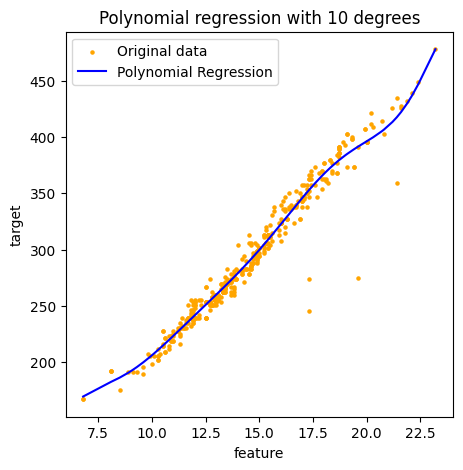

In [37]:
car_emissions = load_car_emissions_dataset()
df_train = car_emissions.set_index('feature', drop=False).sort_index()

X = df_train[['feature']]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=111)

X_poly = expand_dataset(X_train, n_expansions=10, feature_name='feature')
X_poly_test = expand_dataset(X_test, n_expansions=10, feature_name='feature')

lr = LinearRegression()
lr.fit(X_poly, y_train)
preds_train = lr.predict(X_poly)
preds_test = lr.predict(X_poly_test)

X_train_plot, preds_plot = zip(*sorted(zip(X_train.values, preds_train)))

mse = mean_squared_error(y_train, preds_train)
print("Mean squared error (train): {}".format(mse))

r2 = r2_score(y_train, preds_train)
print("R2 score (train): {}".format(r2))

mse = mean_squared_error(y_test, preds_test)
print("Mean squared error (test): {}".format(mse))

r2 = r2_score(y_test, preds_test)
print("R2 score (test): {}".format(r2))

plt.figure(figsize=(5,5))
plt.scatter(X_train, y_train, c='orange', s=5, label="Original data")
plt.plot(X_train_plot, preds_plot, c='blue', label="Polynomial Regression")
plt.title("Polynomial regression with 10 degrees")
plt.legend(loc="best")
plt.xlabel('feature')
plt.ylabel('target')
plt.show();

Seems a bit overfitted. 

### Exercise 4.1

So let's try some regularization techniques. First, remember the L1 loss:

$$J_{L_1} = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$

Start by implementing it in the function below:

In [38]:
def l1_loss(y, y_hat, betas, lamb):
    """
    Implement the L1-loss function 

    Args: 
        y (np.array): numpy array with shape (num_observations,)
            The targets.
        y_hat (np.array): numpy array with shape (num_observations,)
            The predictions.
        betas (np.array): numpy array with shape (num_features+1,)
            The parameters of your regression model. 
            The first value is the intercept and the 
            remaining ones are the feature coefficients.
        lamb (float): The strength of the L1 regularizer.
            
    Returns:
        L (float): loss with L1-regularization
    """
        
    # Compute the mean squared error loss part of the general loss function.
    # Hint: use can use the sklearn function here
    mse = mean_squared_error(y, y_hat)
    
    # Compute the L1 part of the general loss function.
    #betas[1:] the first value is intercept, not needed
    betas_abs_sum = np.sum(np.absolute(betas[1:]))
    l1 = lamb * betas_abs_sum
    
    L = mse + l1
    
    return L

Test your loss function below:

In [39]:
loss1 = l1_loss(
    np.array([0.89305005, 0.53765939, 0.58379047, 0.39355386, 0.30221551, 0.18592352, 0.4025869 , 0.63137406]), 
    np.array([0.23556499, 0.5899186 , 0.77827108, 0.57362455, 0.04727258, 0.99407257, 0.21856487, 0.25006812]), 
    np.array([0.45836509, 0.78367697, 0.6914712]), 
    1
)
np.testing.assert_almost_equal(loss1, 1.6504, 3)

loss1 = l1_loss(
    np.array([0.89305005, 0.53765939, 0.58379047, 0.39355386, 0.30221551, 0.18592352, 0.4025869 , 0.63137406]), 
    np.array([0.23556499, 0.5899186 , 0.77827108, 0.57362455, 0.04727258, 0.99407257, 0.21856487, 0.25006812]), 
    np.array([0.45836509, 0.78367697, 0.6914712]), 
    6
)
np.testing.assert_almost_equal(loss1, 9.0262, 3)


Now let's apply it to our subset of the data and the linear regression we've trained:

In [40]:
car_emissions = load_car_emissions_dataset()
df_train = car_emissions.set_index('feature', drop=False).sort_index()

X = df_train[['feature']]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=111)

X_poly = expand_dataset(X_train, n_expansions=10, feature_name='feature')
X_poly_test = expand_dataset(X_test, n_expansions=10, feature_name='feature')

lr = LinearRegression()
lr.fit(X_poly, y_train)
preds_train = lr.predict(X_poly)
preds_test = lr.predict(X_poly_test)

betas = np.append(lr.intercept_, lr.coef_)

l1_1 = l1_loss(y_train, preds_train, betas, 1)
print("L1 train (beta=1): {}".format(l1_1))

l1_5 = l1_loss(y_train, preds_train, betas, 5)
print("L1 train (beta=5): {}".format(l1_5))


L1 train (beta=1): 693.9351421146705
L1 train (beta=5): 2893.2548393926177


It shouldn't surprise you that the loss gets larger by adding the regularization factor, as we let the linear regression train with focus solely on the mean squared error loss and our coefficients are probably somewhat large. Plot them below:

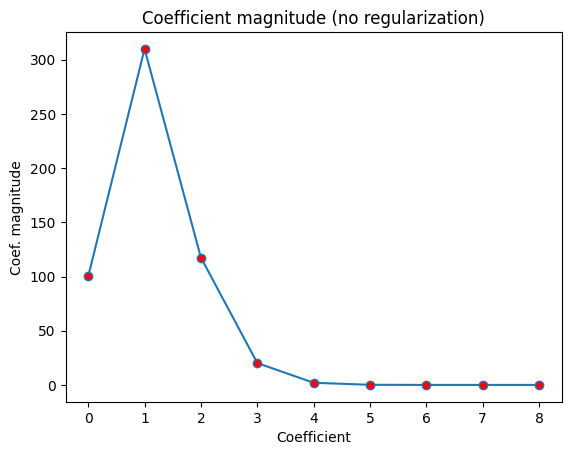

In [41]:
plt.plot(range(len(lr.coef_)), [abs(coef) for coef in lr.coef_], marker='o', markerfacecolor='r')
plt.xlabel('Coefficient')
plt.ylabel('Coef. magnitude')
plt.title("Coefficient magnitude (no regularization)")
plt.show();

### Exercise 4.2

Now let's see what would happen if you would have trained using this regularized loss from the start. 

Implement below the function that fits a regressor using the l1_loss (*Hint: sklearn offers and out of the box estimator for this that you should use*)


In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def l1_loss_lr(X, y, alpha=0.1):
    """
    Fit a linear regressor using the L1-loss with normalize=True and return it 

    Args:
        X (pd.DataFrame): the input DataFrame
        y (pd.Series): the target labels
        alpha (float): the L1 coefficient

    Returns: l1_estimator
        l1_estimator: fitted estimator        
    """
    l1_estimator = make_pipeline(StandardScaler(), Lasso(alpha =alpha, tol = 0.5)) 
    l1_estimator.fit(X,y)
        
    # lasso_lr = ...
    
    return l1_estimator


Test the function below:

In [43]:
car_emissions = load_car_emissions_dataset()
df_train = car_emissions.set_index('feature', drop=False).sort_index()

X = df_train[['feature']]
y = df_train['target']

X_poly = expand_dataset(X, n_expansions=10, feature_name='feature')
lr_l1 = l1_loss_lr(X_poly, y, alpha=0.05)

preds_train = lr_l1.predict(X_poly)

np.testing.assert_almost_equal(preds_train[1], 115.3187, 2)
np.testing.assert_almost_equal(preds_train[41], 209.9796, 2)
np.testing.assert_almost_equal(preds_train[232], 266.9965, 2)
np.testing.assert_almost_equal(preds_train[312], 278.7474, 2)


Now we'll apply this regressor to your data in the same way we did before:

In [44]:
car_emissions = load_car_emissions_dataset()
df_train = car_emissions.set_index('feature', drop=False).sort_index()

X = df_train[['feature']]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=111)

X_poly = expand_dataset(X_train, n_expansions=10, feature_name='feature')
X_poly_test = expand_dataset(X_test, n_expansions=10, feature_name='feature')

lr_l1 = l1_loss_lr(X_poly, y_train, alpha=0.0001)
preds_train = lr_l1.predict(X_poly)
preds_test = lr_l1.predict(X_poly_test)

betas = np.append(lr_l1[1].intercept_, lr_l1[1].coef_)

mse = mean_squared_error(y_train, preds_train)
print("Mean squared error (train): {}".format(mse))

r2 = r2_score(y_train, preds_train)
print("R2 score (train): {}".format(r2))

mse = mean_squared_error(y_test, preds_test)
print("Mean squared error (test): {}".format(mse))

r2 = r2_score(y_test, preds_test)
print("R2 score (test): {}".format(r2))



Mean squared error (train): 161.77530630245772
R2 score (train): 0.95235630069342
Mean squared error (test): 208.51640264702368
R2 score (test): 0.947911147207196


Great, we might not see the improvement in results yet! Finally, we can plot the coefficients for this model and see how complex the model is: 

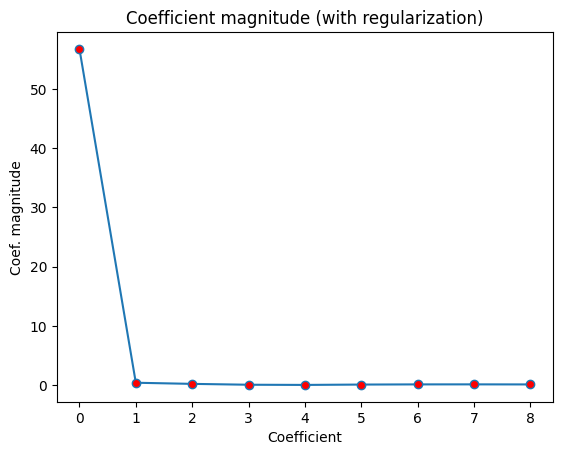

In [45]:
plt.plot(range(len(lr_l1[1].coef_)), [abs(coef) for coef in lr_l1[1].coef_], marker='o', markerfacecolor='r')
plt.xlabel('Coefficient')
plt.ylabel('Coef. magnitude')
plt.title("Coefficient magnitude (with regularization)")
plt.show();

Looks like we only need one variable now, while the rest are pratically null. This typically can help prevent overfitting, as you've seen before.

And that's a wrap!

Congratulations on getting to the end of this exercise notebook. We hope you understood the importance of looking into your data and understanding it, making informed decisions on what features to use and what features to discard. Additionally, you should always keep in mind that starting simple and building from there is a much better approach than choosing overly complex approaches that will become harder to debug.


See you on the next unit! 

</br> 

<img alt="overfitting" src="https://miro.medium.com/max/834/1*aorb7r6PyHhQEZwwT1-_sw.png" width="500">
